In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau, CSVLogger 
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os


%matplotlib inline
import matplotlib.pyplot as plt

# !pip install livelossplot 
from livelossplot import PlotLossesKeras


from keras import backend

from keras.layers import AveragePooling1D, Input, GlobalMaxPooling1D
from keras import layers, models
from keras import backend
import time

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.Session(config=config)


# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

Using TensorFlow backend.


# Data

## Load Data set 

(10299, 128, 3) (10299,)


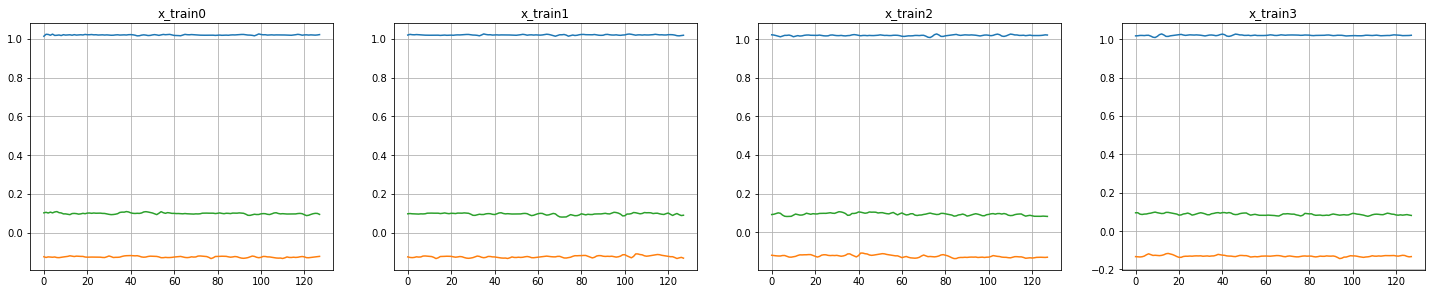

In [2]:
data_type = 'nonsvm'

if data_type == 'svm':
    data_set_path = './data_set/svm'
    save_path = f'./save_file/x_data_6_128_UCI_HAR_svm_acc/'
    x_data = np.load(data_set_path+"/x_data_6_128_UCI_HAR_svm_acc.npy")
    y_data = np.load(data_set_path+"/y_data_6_128_UCI_HAR_svm_acc.npy")
    data_chennal = 1
else:
    data_set_path = './data_set/nonsvm'
    save_path = f'./save_file/x_data_6_128_UCI_HAR_nonsvm_acc/nocrop/'
    x_data = np.load(data_set_path+"/x_data_6_128_UCI_HAR_nonsvm_acc.npy")
    y_data = np.load(data_set_path+"/y_data_6_128_UCI_HAR_nonsvm_acc.npy")

#     data_set_path = './data_set/nonsvm'
#     save_path = './save_file/data_3_100_my_svm_acc+gyro'
#     x_data = np.load(data_set_path+"/x_data_3_100_my_nonsvm_acc+gyro.npy")
#     y_data = np.load(data_set_path+"/y_data_3_100_my_nonsvm_acc+gyro.npy")
    data_chennal = 3
    
# data_set_path = './data_set/my_data/class_9'
# data_set_path = './data_set/svm'

# save_path = './save_file/data_3_100_my_svm'
# save_path = './save_file/data_3_100_my_svm_acc+gyro'

# save_path = f'./save_file/x_data_6_128_UCI_HAR_svm_acc/'


# x_data = np.load(data_set_path+"/x_data_3_100_my_svm_acc+gyro.npy")
# y_data = np.load(data_set_path+"/y_data_3_100_my_svm_acc+gyro.npy")

# x_data = np.load(data_set_path+"/x_data_6_500_hard_svm_acc+gyro.npy")
# y_data = np.load(data_set_path+"/y_data_6_500_hard_svm_acc+gyro.npy")

# x_data = np.load(data_set_path+"/x_data_6_128_UCI_HAR_svm_acc.npy")
# y_data = np.load(data_set_path+"/y_data_6_128_UCI_HAR_svm_acc.npy")


print(x_data.shape, y_data.shape)

data_classes = 6

# # Normalization
# for idx in range(len(x_data)):
#     min = np.min(x_data[idx])
#     max = np.max(x_data[idx])
#     x_data[idx] = (x_data[idx] - min) / (max - min)

# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

# # Standardize
# for idx in range(len(x_data)):
#     standard_deviation = np.std(x_data[idx])
#     mean = np.mean(x_data[idx])
#     x_data[idx] = (x_data[idx] - mean) / standard_deviation


# fig = plt.figure(figsize=(25,10))

# for id in range(4):
#     ax = fig.add_subplot(2,4,id+1)
#     ax.plot(x_data[id])
#     ax.grid(True)
#     ax.set_title(f"x_train{id}")

fig = plt.figure(figsize=(25,10))

for id in range(4):
    ax = fig.add_subplot(2,4,id+1)
    ax.plot(x_data[id])
    ax.grid(True)
    ax.set_title(f"x_train{id}")



## Data split


#data_set_구분
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=1, shuffle=False)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

#y_data onehot encoding
y_train = keras.utils.to_categorical(y_train, data_classes)
y_test = keras.utils.to_categorical(y_test, data_classes)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

## Data packaging

x_train = x_train.reshape(-1, 100,1)
x_test  = x_test.reshape(-1, 100,1)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# k fold cross validation

In [3]:
#y_data onehot encoding
if data_type == 'svm':
    x = x_data.reshape(-1, 128, data_chennal)
else:
#     x = x_data.reshape(-1, 128, data_chennal)
    x = x_data.reshape(-1, 128, data_chennal)

    
y = keras.utils.to_categorical(y_data-1)
print(x.shape, y.shape)


(10299, 128, 3) (10299, 6)


In [4]:

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# 특정 클래스에 대한 정밀도
def single_class_precision(interesting_class_id):
    def prec(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        precision_mask = K.cast(K.equal(class_id_pred, interesting_class_id), 'int32')
        class_prec_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * precision_mask
        class_prec = K.cast(K.sum(class_prec_tensor), 'float32') / K.cast(K.maximum(K.sum(precision_mask), 1), 'float32')
        return class_prec
    return prec


# 특정 클래스에 대한 재현율
def single_class_recall(interesting_class_id):
    def recall(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_pred = K.argmax(y_pred, axis=-1)
        recall_mask = K.cast(K.equal(class_id_true, interesting_class_id), 'int32')
        class_recall_tensor = K.cast(K.equal(class_id_true, class_id_pred), 'int32') * recall_mask
        class_recall = K.cast(K.sum(class_recall_tensor), 'float32') / K.cast(K.maximum(K.sum(recall_mask), 1), 'float32')
        return class_recall
    return recall



# Model

# version 3

In [5]:
# %run ./models/DCNNNet_concate_plus.ipynb
# %run ./models/DCNNNet_concate_plus3.ipynb
# %run ./models/DCNNNet_concate_new.ipynb


%run ./models/DCNNNet_best1.ipynb

# createModel(depth=101, input_shape=(x.shape[1],1), extension_rate=4, classes=data_classes )
createModelNew(input_shape=(x.shape[1], data_chennal), extension_rate=12, classes=data_classes )

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 3)       0                                            
__________________________________________________________________________________________________
zero_padding1d_1 (ZeroPadding1D (None, 134, 3)       0           input[0][0]                      
__________________________________________________________________________________________________
conv1/conv (Conv1D)             (None, 128, 10)      220         zero_padding1d_1[0][0]           
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 128, 10)      40          conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv2_bloc

# traning

In [6]:
if not os.path.isdir(save_path):
    os.makedirs(save_path)

batch_size = 64
split_val = 0.3
fit_shuffle = True
optimizer = 'sgd'
start_lr = 1e-2

split_shuffle = False
history = []
my_models = []

def lr_schedule(epoch):
        lr = start_lr
        if epoch > 225:
            lr *= 1e-2
        elif epoch > 150:
            lr *= 1e-1
        print('epoch: ', epoch)
        print('Learning rate: ', lr)
        return lr
        

    

    
# 3. 모델 학습과정 설정하기
sgd = SGD(lr=lr_schedule(0), decay=1e-4, momentum=0.9, nesterov=True)


# adam = Adam(lr=lr_schedule(0))
# nAdam = Nadam(lr=lr_schedule(0))


# model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])



# modelv3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
#                                                                          f1_m, recall_m, precision_m])



from sklearn.model_selection import StratifiedKFold
# from sklearn.model_selection import StratifiedShuffleSplit
# Instantiate the cross validator

skf = StratifiedKFold(n_splits=3, shuffle=True)
# Loop through the indices the split() method returns

for index, (train_indices, val_indices) in enumerate(skf.split(x_data, y_data)):

#     print(x[train_indices], x[val_indices])
#     print(y[train_indices], y[val_indices])
    xtrain, xval = x[train_indices], x[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]
    
    model = None
#     model = createModel(depth=101, input_shape=(x.shape[1],1), extension_rate=8, classes=data_classes )
    model = createModelNew(input_shape=(x.shape[1], data_chennal), extension_rate=24, classes=data_classes )
    

    
    r_reducer = ReduceLROnPlateau(monitor='val_loss',
                                  verbose=1,
                                  factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
    
#     csv_logger_path = save_path+f'/{index}.{model.name}_nonsvm,ex=24,cropping(k=6),[6,6,6,6],ReduceLROnPlateau_log.csv'
    csv_logger_path = save_path+f'/m1_test2/{index}.{model.name}_test_log.csv'

    if not os.path.isdir(os.path.dirname(csv_logger_path)):
        os.makedirs(os.path.dirname(csv_logger_path))
    csv_logger = CSVLogger(csv_logger_path, append=True)

    lr_scheduler = LearningRateScheduler(schedule=lr_schedule)

    callbacks = [lr_scheduler, lr_scheduler, csv_logger]


    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy',
                                                              
                                                                single_class_precision(0), single_class_recall(0),
                                                                single_class_precision(1), single_class_recall(1),
                                                                single_class_precision(2), single_class_recall(2),
                                                                single_class_precision(3), single_class_recall(3),
                                                                single_class_precision(4), single_class_recall(4),
                                                                single_class_precision(5), single_class_recall(5),
#                                                                 single_class_precision(6), single_class_recall(6),
#                                                                 single_class_precision(7), single_class_recall(7),
#                                                                 single_class_precision(8), single_class_recall(8)
                                                                            f1_m, recall_m, precision_m
                                                                          ]) 
    
    
    history.append(model.fit(xtrain, ytrain, 
                        epochs=600, batch_size=batch_size, 
                        shuffle=fit_shuffle,
#                         workers=4, 
                        validation_data=(xval, yval),
                        callbacks=callbacks))

    my_models.append(model)
ㄴ
# # 4. 모델 학습시키기
# history = modelv3.fit(x_train, y_train, 
#                     epochs=300, batch_size=batch_size, 
#                     shuffle=fit_shuffle,
# #                     workers=1, 
#                       validation_data=(x_test, y_test),
#                     callbacks=callbacks)

# histories[model] = models[model].fit(x_train, y_train, epochs=300, batch_size=32, workers=4, validation_data=(x_train, y_train))

# 6. 모델 평가하기
# evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)



epoch:  0
Learning rate:  0.01
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 3)       0                                            
__________________________________________________________________________________________________
zero_padding1d_2 (ZeroPadding1D (None, 134, 3)       0           input[0][0]                      
__________________________________________________________________________________________________
conv1/conv (Conv1D)             (None, 128, 10)      220         zero_padding1d_2[0][0]           
__________________________________________________________________________________________________
conv2_block1_0_bn (BatchNormali (None, 128, 10)      40          conv1/conv[0][0]                 
______________________________________________________________________________

Train on 6864 samples, validate on 3435 samples
Epoch 1/600
epoch:  0
Learning rate:  0.01
epoch:  0
Learning rate:  0.01
6864/6864 [==============================] - 39s 6ms/step - loss: 0.3568 - acc: 0.8610 - prec: 0.8596 - recall: 0.8730 - prec_1: 0.8717 - recall_1: 0.8691 - prec_2: 0.8991 - recall_2: 0.9041 - prec_3: 0.7605 - recall_3: 0.7802 - prec_4: 0.8206 - recall_4: 0.8035 - prec_5: 0.9693 - recall_5: 0.9716 - f1_m: 0.8446 - recall_m: 0.8253 - precision_m: 0.8876 - val_loss: 1.9892 - val_acc: 0.6157 - val_prec: 0.2403 - val_recall: 0.2636 - val_prec_1: 0.4590 - val_recall_1: 0.9365 - val_prec_2: 0.9293 - val_recall_2: 0.9979 - val_prec_3: 0.6740 - val_recall_3: 0.4934 - val_prec_4: 0.1580 - val_recall_4: 0.0925 - val_prec_5: 0.9969 - val_recall_5: 0.9943 - val_f1_m: 0.6154 - val_recall_m: 0.6035 - val_precision_m: 0.6287
Epoch 2/600
epoch:  1
Learning rate:  0.01
epoch:  1
Learning rate:  0.01
6864/6864 [==============================] - 15s 2ms/step - loss: 0.1579 - acc: 0.93

6864/6864 [==============================] - 15s 2ms/step - loss: 0.1096 - acc: 0.9543 - prec: 0.9967 - recall: 0.9987 - prec_1: 0.9934 - recall_1: 0.9950 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8550 - recall_3: 0.8899 - prec_4: 0.8934 - recall_4: 0.8693 - prec_5: 1.0000 - recall_5: 0.9994 - f1_m: 0.9542 - recall_m: 0.9541 - precision_m: 0.9544 - val_loss: 0.1844 - val_acc: 0.9240 - val_prec: 0.9873 - val_recall: 1.0000 - val_prec_1: 0.8668 - val_recall_1: 0.9816 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8736 - val_recall_3: 0.6609 - val_prec_4: 0.8477 - val_recall_4: 0.9102 - val_prec_5: 1.0000 - val_recall_5: 0.9984 - val_f1_m: 0.9238 - val_recall_m: 0.9214 - val_precision_m: 0.9263
Epoch 12/600
epoch:  11
Learning rate:  0.01
epoch:  11
Learning rate:  0.01
6864/6864 [==============================] - 15s 2ms/step - loss: 0.1200 - acc: 0.9505 - prec: 0.9942 - recall: 0.9995 - prec_1: 0.9983 - recall_1: 0.9943 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6864/6864 [==============================] - 14s 2ms/step - loss: 0.1024 - acc: 0.9551 - prec: 0.9991 - recall: 0.9995 - prec_1: 0.9990 - recall_1: 0.9994 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8584 - recall_3: 0.8981 - prec_4: 0.8952 - recall_4: 0.8682 - prec_5: 0.9995 - recall_5: 0.9995 - f1_m: 0.9550 - recall_m: 0.9548 - precision_m: 0.9551 - val_loss: 0.0878 - val_acc: 0.9613 - val_prec: 0.9977 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9969 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8657 - val_recall_3: 0.8971 - val_prec_4: 0.8844 - val_recall_4: 0.8554 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9611 - val_recall_m: 0.9610 - val_precision_m: 0.9613
Epoch 22/600
epoch:  21
Learning rate:  0.01
epoch:  21
Learning rate:  0.01
6864/6864 [==============================] - 12s 2ms/step - loss: 0.1007 - acc: 0.9591 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6864/6864 [==============================] - 13s 2ms/step - loss: 0.1054 - acc: 0.9541 - prec: 1.0000 - recall: 0.9977 - prec_1: 0.9971 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9970 - prec_3: 0.8562 - recall_3: 0.8937 - prec_4: 0.8856 - recall_4: 0.8691 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9540 - recall_m: 0.9540 - precision_m: 0.9541 - val_loss: 0.1036 - val_acc: 0.9549 - val_prec: 0.9943 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9935 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8731 - val_recall_3: 0.8845 - val_prec_4: 0.8892 - val_recall_4: 0.8414 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9551 - val_recall_m: 0.9549 - val_precision_m: 0.9554
Epoch 32/600
epoch:  31
Learning rate:  0.01
epoch:  31
Learning rate:  0.01
6864/6864 [==============================] - 13s 2ms/step - loss: 0.1057 - acc: 0.9532 - prec: 0.9961 - recall: 0.9988 - prec_1: 0.9987 - recall_1: 0.9971 - prec_2: 1.0000 - recall_2: 0.9995 - prec_3: 0.

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0962 - acc: 0.9578 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8867 - recall_3: 0.8719 - prec_4: 0.8793 - recall_4: 0.8967 - prec_5: 1.0000 - recall_5: 0.9996 - f1_m: 0.9576 - recall_m: 0.9575 - precision_m: 0.9577 - val_loss: 0.0854 - val_acc: 0.9598 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8709 - val_recall_3: 0.8835 - val_prec_4: 0.8855 - val_recall_4: 0.8616 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9598 - val_recall_m: 0.9598 - val_precision_m: 0.9598
Epoch 42/600
epoch:  41
Learning rate:  0.01
epoch:  41
Learning rate:  0.01
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0973 - acc: 0.9575 - prec: 0.9981 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0970 - acc: 0.9595 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8769 - recall_3: 0.8948 - prec_4: 0.9003 - recall_4: 0.8839 - prec_5: 0.9981 - recall_5: 0.9992 - f1_m: 0.9595 - recall_m: 0.9595 - precision_m: 0.9595 - val_loss: 0.0839 - val_acc: 0.9639 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8918 - val_recall_3: 0.8691 - val_prec_4: 0.9026 - val_recall_4: 0.9006 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9640 - val_recall_m: 0.9639 - val_precision_m: 0.9642
Epoch 52/600
epoch:  51
Learning rate:  0.01
epoch:  51
Learning rate:  0.01
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0962 - acc: 0.9585 - prec: 0.9988 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9993 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0957 - acc: 0.9599 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.8801 - recall_3: 0.8915 - prec_4: 0.8961 - recall_4: 0.8884 - prec_5: 1.0000 - recall_5: 0.9994 - f1_m: 0.9599 - recall_m: 0.9599 - precision_m: 0.9599 - val_loss: 0.0873 - val_acc: 0.9601 - val_prec: 0.9981 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9977 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8853 - val_recall_3: 0.8517 - val_prec_4: 0.8903 - val_recall_4: 0.9013 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9601 - val_recall_m: 0.9601 - val_precision_m: 0.9601
Epoch 62/600
epoch:  61
Learning rate:  0.01
epoch:  61
Learning rate:  0.01
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0899 - acc: 0.9607 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9984 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9993 - prec_3: 0.

6864/6864 [==============================] - 15s 2ms/step - loss: 0.0909 - acc: 0.9628 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8831 - recall_3: 0.9047 - prec_4: 0.9073 - recall_4: 0.8935 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9628 - recall_m: 0.9628 - precision_m: 0.9628 - val_loss: 0.0887 - val_acc: 0.9604 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8921 - val_recall_3: 0.8410 - val_prec_4: 0.8844 - val_recall_4: 0.9084 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9604 - val_recall_m: 0.9604 - val_precision_m: 0.9604
Epoch 72/600
epoch:  71
Learning rate:  0.01
epoch:  71
Learning rate:  0.01
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0887 - acc: 0.9602 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9996 - prec_2: 0.9967 - recall_2: 0.9977 - prec_3: 0.

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0884 - acc: 0.9620 - prec: 1.0000 - recall: 0.9989 - prec_1: 0.9992 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8846 - recall_3: 0.8954 - prec_4: 0.8911 - recall_4: 0.8951 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9620 - recall_m: 0.9620 - precision_m: 0.9620 - val_loss: 0.0867 - val_acc: 0.9616 - val_prec: 0.9891 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9850 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8676 - val_recall_3: 0.9044 - val_prec_4: 0.9210 - val_recall_4: 0.8660 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9617 - val_recall_m: 0.9616 - val_precision_m: 0.9619
Epoch 82/600
epoch:  81
Learning rate:  0.01
epoch:  81
Learning rate:  0.01
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0898 - acc: 0.9646 - prec: 0.9938 - recall: 0.9966 - prec_1: 0.9975 - recall_1: 0.9965 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0818 - acc: 0.9633 - prec: 1.0000 - recall: 0.9990 - prec_1: 0.9981 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8949 - recall_3: 0.9032 - prec_4: 0.8995 - recall_4: 0.8981 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9633 - recall_m: 0.9633 - precision_m: 0.9633 - val_loss: 0.0978 - val_acc: 0.9619 - val_prec: 0.9969 - val_recall: 0.9986 - val_prec_1: 1.0000 - val_recall_1: 0.9983 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8605 - val_recall_3: 0.9073 - val_prec_4: 0.9225 - val_recall_4: 0.8595 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9619 - val_recall_m: 0.9619 - val_precision_m: 0.9619
Epoch 92/600
epoch:  91
Learning rate:  0.01
epoch:  91
Learning rate:  0.01
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0872 - acc: 0.9640 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0781 - acc: 0.9688 - prec: 1.0000 - recall: 0.9990 - prec_1: 0.9988 - recall_1: 0.9994 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8979 - recall_3: 0.9202 - prec_4: 0.9204 - recall_4: 0.9074 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9688 - recall_m: 0.9688 - precision_m: 0.9688 - val_loss: 0.0788 - val_acc: 0.9659 - val_prec: 1.0000 - val_recall: 0.9986 - val_prec_1: 1.0000 - val_recall_1: 0.9986 - val_prec_2: 0.9986 - val_recall_2: 1.0000 - val_prec_3: 0.9027 - val_recall_3: 0.8871 - val_prec_4: 0.9070 - val_recall_4: 0.9016 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9658 - val_recall_m: 0.9656 - val_precision_m: 0.9659
Epoch 102/600
epoch:  101
Learning rate:  0.01
epoch:  101
Learning rate:  0.01
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0734 - acc: 0.9690 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0785 - acc: 0.9668 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8995 - recall_3: 0.9055 - prec_4: 0.9106 - recall_4: 0.9110 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9669 - recall_m: 0.9668 - precision_m: 0.9669 - val_loss: 0.0848 - val_acc: 0.9659 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9215 - val_recall_3: 0.8528 - val_prec_4: 0.8848 - val_recall_4: 0.9278 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9658 - val_recall_m: 0.9656 - val_precision_m: 0.9659
Epoch 112/600
epoch:  111
Learning rate:  0.01
epoch:  111
Learning rate:  0.01
6864/6864 [==============================] - 15s 2ms/step - loss: 0.0742 - acc: 0.9703 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3:

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0686 - acc: 0.9717 - prec: 0.9990 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9200 - recall_3: 0.9165 - prec_4: 0.9242 - recall_4: 0.9288 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9717 - recall_m: 0.9717 - precision_m: 0.9717 - val_loss: 0.0969 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8988 - val_recall_3: 0.8274 - val_prec_4: 0.8683 - val_recall_4: 0.9160 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9608 - val_recall_m: 0.9607 - val_precision_m: 0.9610
Epoch 122/600
epoch:  121
Learning rate:  0.01
epoch:  121
Learning rate:  0.01
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0675 - acc: 0.9726 - prec: 0.9992 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9988 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0604 - acc: 0.9757 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9977 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9987 - prec_3: 0.9359 - recall_3: 0.9276 - prec_4: 0.9291 - recall_4: 0.9418 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9757 - recall_m: 0.9757 - precision_m: 0.9757 - val_loss: 0.1096 - val_acc: 0.9584 - val_prec: 1.0000 - val_recall: 0.9986 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8849 - val_recall_3: 0.8848 - val_prec_4: 0.8736 - val_recall_4: 0.8609 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9584 - val_recall_m: 0.9584 - val_precision_m: 0.9584
Epoch 132/600
epoch:  131
Learning rate:  0.01
epoch:  131
Learning rate:  0.01
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0613 - acc: 0.9736 - prec: 0.9977 - recall: 0.9977 - prec_1: 1.0000 - recall_1: 0.9995 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3:

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0564 - acc: 0.9770 - prec: 0.9990 - recall: 1.0000 - prec_1: 0.9977 - recall_1: 0.9977 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9343 - recall_3: 0.9328 - prec_4: 0.9411 - recall_4: 0.9441 - prec_5: 0.9992 - recall_5: 0.9976 - f1_m: 0.9770 - recall_m: 0.9770 - precision_m: 0.9770 - val_loss: 0.1060 - val_acc: 0.9572 - val_prec: 0.9981 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9977 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8497 - val_recall_3: 0.9150 - val_prec_4: 0.9206 - val_recall_4: 0.8176 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9572 - val_recall_m: 0.9572 - val_precision_m: 0.9572
Epoch 142/600
epoch:  141
Learning rate:  0.01
epoch:  141
Learning rate:  0.01
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0602 - acc: 0.9763 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0465 - acc: 0.9827 - prec: 1.0000 - recall: 0.9995 - prec_1: 0.9969 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9571 - recall_3: 0.9473 - prec_4: 0.9519 - recall_4: 0.9589 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9827 - recall_m: 0.9827 - precision_m: 0.9828 - val_loss: 0.1226 - val_acc: 0.9479 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8302 - val_recall_3: 0.8725 - val_prec_4: 0.8768 - val_recall_4: 0.8097 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9479 - val_recall_m: 0.9479 - val_precision_m: 0.9479
Epoch 152/600
epoch:  151
Learning rate:  0.001
epoch:  151
Learning rate:  0.001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0439 - acc: 0.9822 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0251 - acc: 0.9920 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9760 - recall_3: 0.9779 - prec_4: 0.9784 - recall_4: 0.9796 - prec_5: 1.0000 - recall_5: 0.9996 - f1_m: 0.9920 - recall_m: 0.9920 - precision_m: 0.9920 - val_loss: 0.1053 - val_acc: 0.9633 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8920 - val_recall_3: 0.8650 - val_prec_4: 0.8899 - val_recall_4: 0.8939 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9633 - val_recall_m: 0.9633 - val_precision_m: 0.9633
Epoch 162/600
epoch:  161
Learning rate:  0.001
epoch:  161
Learning rate:  0.001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0227 - acc: 0.9929 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0220 - acc: 0.9932 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9844 - recall_3: 0.9783 - prec_4: 0.9782 - recall_4: 0.9837 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9932 - recall_m: 0.9932 - precision_m: 0.9932 - val_loss: 0.1093 - val_acc: 0.9627 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8870 - val_recall_3: 0.8732 - val_prec_4: 0.8989 - val_recall_4: 0.8857 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9627 - val_recall_m: 0.9627 - val_precision_m: 0.9627
Epoch 172/600
epoch:  171
Learning rate:  0.001
epoch:  171
Learning rate:  0.001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0224 - acc: 0.9934 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0191 - acc: 0.9934 - prec: 0.9988 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9803 - recall_3: 0.9841 - prec_4: 0.9833 - recall_4: 0.9834 - prec_5: 1.0000 - recall_5: 0.9996 - f1_m: 0.9934 - recall_m: 0.9934 - precision_m: 0.9934 - val_loss: 0.1145 - val_acc: 0.9619 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8805 - val_recall_3: 0.8734 - val_prec_4: 0.8950 - val_recall_4: 0.8761 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9619 - val_recall_m: 0.9619 - val_precision_m: 0.9619
Epoch 182/600
epoch:  181
Learning rate:  0.001
epoch:  181
Learning rate:  0.001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0179 - acc: 0.9943 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0188 - acc: 0.9934 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9841 - recall_3: 0.9792 - prec_4: 0.9795 - recall_4: 0.9848 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9934 - recall_m: 0.9934 - precision_m: 0.9934 - val_loss: 0.1169 - val_acc: 0.9627 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8832 - val_recall_3: 0.8730 - val_prec_4: 0.8958 - val_recall_4: 0.8844 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9626 - val_recall_m: 0.9624 - val_precision_m: 0.9627
Epoch 192/600
epoch:  191
Learning rate:  0.001
epoch:  191
Learning rate:  0.001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0142 - acc: 0.9959 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - prec_

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0184 - acc: 0.9950 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.9888 - recall_3: 0.9844 - prec_4: 0.9829 - recall_4: 0.9892 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9950 - recall_m: 0.9950 - precision_m: 0.9950 - val_loss: 0.1194 - val_acc: 0.9624 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8781 - val_recall_3: 0.8771 - val_prec_4: 0.9006 - val_recall_4: 0.8770 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9624 - val_recall_m: 0.9624 - val_precision_m: 0.9624
Epoch 202/600
epoch:  201
Learning rate:  0.001
epoch:  201
Learning rate:  0.001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0149 - acc: 0.9953 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0171 - acc: 0.9949 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9862 - recall_3: 0.9856 - prec_4: 0.9898 - recall_4: 0.9863 - prec_5: 0.9953 - recall_5: 1.0000 - f1_m: 0.9949 - recall_m: 0.9949 - precision_m: 0.9949 - val_loss: 0.1285 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8800 - val_recall_3: 0.8660 - val_prec_4: 0.8920 - val_recall_4: 0.8828 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9605 - val_recall_m: 0.9604 - val_precision_m: 0.9607
Epoch 212/600
epoch:  211
Learning rate:  0.001
epoch:  211
Learning rate:  0.001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0117 - acc: 0.9969 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0148 - acc: 0.9948 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9887 - recall_3: 0.9836 - prec_4: 0.9822 - recall_4: 0.9892 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9948 - recall_m: 0.9948 - precision_m: 0.9948 - val_loss: 0.1311 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8797 - val_recall_3: 0.8708 - val_prec_4: 0.8951 - val_recall_4: 0.8780 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 222/600
epoch:  221
Learning rate:  0.001
epoch:  221
Learning rate:  0.001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0135 - acc: 0.9958 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0126 - acc: 0.9962 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9872 - recall_3: 0.9898 - prec_4: 0.9880 - recall_4: 0.9897 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9962 - recall_m: 0.9962 - precision_m: 0.9962 - val_loss: 0.1323 - val_acc: 0.9598 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8803 - val_recall_3: 0.8643 - val_prec_4: 0.8927 - val_recall_4: 0.8806 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9598 - val_recall_m: 0.9598 - val_precision_m: 0.9598
Epoch 232/600
epoch:  231
Learning rate:  0.0001
epoch:  231
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0132 - acc: 0.9958 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0130 - acc: 0.9965 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9908 - recall_3: 0.9888 - prec_4: 0.9854 - recall_4: 0.9939 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9965 - recall_m: 0.9965 - precision_m: 0.9965 - val_loss: 0.1318 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8830 - val_recall_3: 0.8650 - val_prec_4: 0.8967 - val_recall_4: 0.8844 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 242/600
epoch:  241
Learning rate:  0.0001
epoch:  241
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0123 - acc: 0.9962 - prec: 1.0000 - recall: 0.9986 - prec_1: 0.9983 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0103 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9925 - recall_3: 0.9958 - prec_4: 0.9963 - recall_4: 0.9938 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9980 - recall_m: 0.9980 - precision_m: 0.9980 - val_loss: 0.1323 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8784 - val_recall_3: 0.8708 - val_prec_4: 0.8980 - val_recall_4: 0.8791 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 252/600
epoch:  251
Learning rate:  0.0001
epoch:  251
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0098 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - pre

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0117 - acc: 0.9965 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9878 - recall_3: 0.9883 - prec_4: 0.9888 - recall_4: 0.9914 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9965 - recall_m: 0.9965 - precision_m: 0.9965 - val_loss: 0.1324 - val_acc: 0.9616 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8774 - val_recall_3: 0.8753 - val_prec_4: 0.8991 - val_recall_4: 0.8760 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9616 - val_recall_m: 0.9616 - val_precision_m: 0.9616
Epoch 262/600
epoch:  261
Learning rate:  0.0001
epoch:  261
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0111 - acc: 0.9965 - prec: 0.9977 - recall: 0.9977 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0121 - acc: 0.9961 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.9919 - recall_3: 0.9873 - prec_4: 0.9852 - recall_4: 0.9930 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9961 - recall_m: 0.9961 - precision_m: 0.9961 - val_loss: 0.1328 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8781 - val_recall_3: 0.8698 - val_prec_4: 0.8965 - val_recall_4: 0.8773 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 272/600
epoch:  271
Learning rate:  0.0001
epoch:  271
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0087 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0104 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9903 - recall_3: 0.9941 - prec_4: 0.9935 - recall_4: 0.9922 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - val_loss: 0.1328 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8763 - val_recall_3: 0.8708 - val_prec_4: 0.8981 - val_recall_4: 0.8760 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 282/600
epoch:  281
Learning rate:  0.0001
epoch:  281
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0131 - acc: 0.9968 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0109 - acc: 0.9965 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9869 - recall_3: 0.9877 - prec_4: 0.9875 - recall_4: 0.9926 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9965 - recall_m: 0.9965 - precision_m: 0.9965 - val_loss: 0.1332 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8763 - val_recall_3: 0.8698 - val_prec_4: 0.8963 - val_recall_4: 0.8760 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 292/600
epoch:  291
Learning rate:  0.0001
epoch:  291
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0086 - acc: 0.9983 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0099 - acc: 0.9975 - prec: 0.9992 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9988 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.9966 - recall_3: 0.9936 - prec_4: 0.9910 - recall_4: 0.9953 - prec_5: 0.9977 - recall_5: 0.9977 - f1_m: 0.9976 - recall_m: 0.9975 - precision_m: 0.9976 - val_loss: 0.1334 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8775 - val_recall_3: 0.8719 - val_prec_4: 0.8990 - val_recall_4: 0.8762 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 302/600
epoch:  301
Learning rate:  0.0001
epoch:  301
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0122 - acc: 0.9974 - prec: 0.9977 - recall: 0.9977 - prec_1: 1.0000 - recall_1: 0.9997 - prec_2: 0.9977 - recall_2: 0.9977 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0087 - acc: 0.9978 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9944 - recall_3: 0.9926 - prec_4: 0.9936 - recall_4: 0.9961 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9978 - recall_m: 0.9978 - precision_m: 0.9978 - val_loss: 0.1347 - val_acc: 0.9619 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8757 - val_recall_3: 0.8770 - val_prec_4: 0.9020 - val_recall_4: 0.8749 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9619 - val_recall_m: 0.9619 - val_precision_m: 0.9619
Epoch 312/600
epoch:  311
Learning rate:  0.0001
epoch:  311
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0109 - acc: 0.9966 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0096 - acc: 0.9974 - prec: 1.0000 - recall: 0.9991 - prec_1: 0.9967 - recall_1: 0.9977 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9942 - recall_3: 0.9908 - prec_4: 0.9923 - recall_4: 0.9951 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - val_loss: 0.1343 - val_acc: 0.9616 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8781 - val_recall_3: 0.8725 - val_prec_4: 0.9006 - val_recall_4: 0.8791 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9616 - val_recall_m: 0.9616 - val_precision_m: 0.9616
Epoch 322/600
epoch:  321
Learning rate:  0.0001
epoch:  321
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0104 - acc: 0.9968 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0099 - acc: 0.9972 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9919 - recall_3: 0.9932 - prec_4: 0.9925 - recall_4: 0.9923 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9972 - recall_m: 0.9972 - precision_m: 0.9972 - val_loss: 0.1342 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8781 - val_recall_3: 0.8684 - val_prec_4: 0.8961 - val_recall_4: 0.8791 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 332/600
epoch:  331
Learning rate:  0.0001
epoch:  331
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0080 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0113 - acc: 0.9965 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9926 - recall_3: 0.9902 - prec_4: 0.9868 - recall_4: 0.9917 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9965 - recall_m: 0.9965 - precision_m: 0.9965 - val_loss: 0.1342 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8765 - val_recall_3: 0.8715 - val_prec_4: 0.8971 - val_recall_4: 0.8768 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 342/600
epoch:  341
Learning rate:  0.0001
epoch:  341
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0102 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0124 - acc: 0.9959 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9846 - recall_3: 0.9935 - prec_4: 0.9899 - recall_4: 0.9877 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9959 - recall_m: 0.9959 - precision_m: 0.9959 - val_loss: 0.1351 - val_acc: 0.9604 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8772 - val_recall_3: 0.8684 - val_prec_4: 0.8940 - val_recall_4: 0.8762 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9604 - val_recall_m: 0.9604 - val_precision_m: 0.9604
Epoch 352/600
epoch:  351
Learning rate:  0.0001
epoch:  351
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0107 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0095 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9977 - recall_1: 0.9977 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9916 - recall_3: 0.9900 - prec_4: 0.9918 - recall_4: 0.9936 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - val_loss: 0.1354 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8756 - val_recall_3: 0.8711 - val_prec_4: 0.8967 - val_recall_4: 0.8754 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 362/600
epoch:  361
Learning rate:  0.0001
epoch:  361
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0097 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0102 - acc: 0.9977 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9927 - recall_3: 0.9936 - prec_4: 0.9928 - recall_4: 0.9942 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9977 - recall_m: 0.9977 - precision_m: 0.9977 - val_loss: 0.1363 - val_acc: 0.9604 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8757 - val_recall_3: 0.8698 - val_prec_4: 0.8961 - val_recall_4: 0.8749 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9602 - val_recall_m: 0.9601 - val_precision_m: 0.9604
Epoch 372/600
epoch:  371
Learning rate:  0.0001
epoch:  371
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0105 - acc: 0.9966 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0081 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9937 - recall_3: 0.9927 - prec_4: 0.9944 - recall_4: 0.9960 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9980 - recall_m: 0.9980 - precision_m: 0.9980 - val_loss: 0.1363 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8781 - val_recall_3: 0.8661 - val_prec_4: 0.8960 - val_recall_4: 0.8795 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 382/600
epoch:  381
Learning rate:  0.0001
epoch:  381
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0084 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0077 - acc: 0.9985 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9955 - recall_3: 0.9960 - prec_4: 0.9940 - recall_4: 0.9969 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9985 - recall_m: 0.9985 - precision_m: 0.9985 - val_loss: 0.1369 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8774 - val_recall_3: 0.8725 - val_prec_4: 0.9002 - val_recall_4: 0.8780 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 392/600
epoch:  391
Learning rate:  0.0001
epoch:  391
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0100 - acc: 0.9969 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0089 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - prec_3: 0.9940 - recall_3: 0.9910 - prec_4: 0.9896 - recall_4: 0.9960 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - val_loss: 0.1364 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8774 - val_recall_3: 0.8725 - val_prec_4: 0.9004 - val_recall_4: 0.8780 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 402/600
epoch:  401
Learning rate:  0.0001
epoch:  401
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0086 - acc: 0.9985 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9977 - recall_1: 0.9977 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0107 - acc: 0.9966 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9934 - recall_3: 0.9889 - prec_4: 0.9888 - recall_4: 0.9924 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9966 - recall_m: 0.9966 - precision_m: 0.9966 - val_loss: 0.1373 - val_acc: 0.9616 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8793 - val_recall_3: 0.8725 - val_prec_4: 0.9006 - val_recall_4: 0.8793 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9616 - val_recall_m: 0.9616 - val_precision_m: 0.9616
Epoch 412/600
epoch:  411
Learning rate:  0.0001
epoch:  411
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0102 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0082 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9941 - recall_3: 0.9937 - prec_4: 0.9923 - recall_4: 0.9946 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9980 - recall_m: 0.9980 - precision_m: 0.9980 - val_loss: 0.1375 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8757 - val_recall_3: 0.8725 - val_prec_4: 0.8991 - val_recall_4: 0.8749 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 422/600
epoch:  421
Learning rate:  0.0001
epoch:  421
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0086 - acc: 0.9981 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0085 - acc: 0.9978 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9922 - recall_3: 0.9948 - prec_4: 0.9935 - recall_4: 0.9946 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9978 - recall_m: 0.9978 - precision_m: 0.9978 - val_loss: 0.1382 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8774 - val_recall_3: 0.8709 - val_prec_4: 0.8991 - val_recall_4: 0.8780 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 432/600
epoch:  431
Learning rate:  0.0001
epoch:  431
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0084 - acc: 0.9981 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0097 - acc: 0.9966 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9884 - recall_3: 0.9913 - prec_4: 0.9921 - recall_4: 0.9908 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9966 - recall_m: 0.9966 - precision_m: 0.9966 - val_loss: 0.1373 - val_acc: 0.9619 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8783 - val_recall_3: 0.8722 - val_prec_4: 0.9010 - val_recall_4: 0.8799 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9619 - val_recall_m: 0.9619 - val_precision_m: 0.9619
Epoch 442/600
epoch:  441
Learning rate:  0.0001
epoch:  441
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0074 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0103 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9926 - recall_3: 0.9929 - prec_4: 0.9935 - recall_4: 0.9949 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9975 - recall_m: 0.9975 - precision_m: 0.9975 - val_loss: 0.1384 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8783 - val_recall_3: 0.8663 - val_prec_4: 0.8954 - val_recall_4: 0.8799 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 452/600
epoch:  451
Learning rate:  0.0001
epoch:  451
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0092 - acc: 0.9977 - prec: 0.9991 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9993 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0094 - acc: 0.9977 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9945 - recall_3: 0.9911 - prec_4: 0.9910 - recall_4: 0.9964 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9977 - recall_m: 0.9977 - precision_m: 0.9977 - val_loss: 0.1385 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8793 - val_recall_3: 0.8708 - val_prec_4: 0.8994 - val_recall_4: 0.8793 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 462/600
epoch:  461
Learning rate:  0.0001
epoch:  461
Learning rate:  0.0001
6864/6864 [==============================] - 15s 2ms/step - loss: 0.0099 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0087 - acc: 0.9977 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9941 - recall_3: 0.9927 - prec_4: 0.9942 - recall_4: 0.9945 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9976 - recall_m: 0.9975 - precision_m: 0.9977 - val_loss: 0.1385 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8772 - val_recall_3: 0.8691 - val_prec_4: 0.8963 - val_recall_4: 0.8762 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 472/600
epoch:  471
Learning rate:  0.0001
epoch:  471
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0075 - acc: 0.9978 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9977 - recall_2: 0.9977 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0093 - acc: 0.9978 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9919 - recall_3: 0.9964 - prec_4: 0.9968 - recall_4: 0.9937 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9978 - recall_m: 0.9978 - precision_m: 0.9978 - val_loss: 0.1386 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8775 - val_recall_3: 0.8711 - val_prec_4: 0.8990 - val_recall_4: 0.8762 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9611 - val_recall_m: 0.9610 - val_precision_m: 0.9612
Epoch 482/600
epoch:  481
Learning rate:  0.0001
epoch:  481
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0096 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9994 - prec_2: 0.9969 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0071 - acc: 0.9977 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9917 - recall_3: 0.9958 - prec_4: 0.9927 - recall_4: 0.9926 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9977 - recall_m: 0.9977 - precision_m: 0.9977 - val_loss: 0.1389 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8757 - val_recall_3: 0.8694 - val_prec_4: 0.8979 - val_recall_4: 0.8749 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9605 - val_recall_m: 0.9604 - val_precision_m: 0.9607
Epoch 492/600
epoch:  491
Learning rate:  0.0001
epoch:  491
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0103 - acc: 0.9966 - prec: 0.9977 - recall: 0.9977 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0104 - acc: 0.9965 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9876 - recall_3: 0.9911 - prec_4: 0.9911 - recall_4: 0.9905 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9965 - recall_m: 0.9965 - precision_m: 0.9965 - val_loss: 0.1389 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8805 - val_recall_3: 0.8684 - val_prec_4: 0.8962 - val_recall_4: 0.8818 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9611 - val_recall_m: 0.9610 - val_precision_m: 0.9613
Epoch 502/600
epoch:  501
Learning rate:  0.0001
epoch:  501
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0081 - acc: 0.9980 - prec: 0.9977 - recall: 0.9977 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0084 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9893 - recall_3: 0.9917 - prec_4: 0.9948 - recall_4: 0.9935 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9975 - recall_m: 0.9975 - precision_m: 0.9975 - val_loss: 0.1398 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8777 - val_recall_3: 0.8694 - val_prec_4: 0.8975 - val_recall_4: 0.8765 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 512/600
epoch:  511
Learning rate:  0.0001
epoch:  511
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0099 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0092 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9956 - recall_3: 0.9919 - prec_4: 0.9879 - recall_4: 0.9955 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9975 - recall_m: 0.9975 - precision_m: 0.9975 - val_loss: 0.1400 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8789 - val_recall_3: 0.8674 - val_prec_4: 0.8954 - val_recall_4: 0.8790 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9610 - val_recall_m: 0.9610 - val_precision_m: 0.9610
Epoch 522/600
epoch:  521
Learning rate:  0.0001
epoch:  521
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0066 - acc: 0.9988 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0106 - acc: 0.9968 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9913 - recall_3: 0.9902 - prec_4: 0.9908 - recall_4: 0.9914 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9968 - recall_m: 0.9968 - precision_m: 0.9968 - val_loss: 0.1399 - val_acc: 0.9604 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8777 - val_recall_3: 0.8670 - val_prec_4: 0.8941 - val_recall_4: 0.8765 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9604 - val_recall_m: 0.9604 - val_precision_m: 0.9604
Epoch 532/600
epoch:  531
Learning rate:  0.0001
epoch:  531
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0091 - acc: 0.9966 - prec: 0.9988 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9994 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0085 - acc: 0.9974 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9912 - recall_3: 0.9929 - prec_4: 0.9904 - recall_4: 0.9935 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9974 - recall_m: 0.9974 - precision_m: 0.9974 - val_loss: 0.1401 - val_acc: 0.9619 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8811 - val_recall_3: 0.8680 - val_prec_4: 0.8954 - val_recall_4: 0.8840 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9619 - val_recall_m: 0.9619 - val_precision_m: 0.9619
Epoch 542/600
epoch:  541
Learning rate:  0.0001
epoch:  541
Learning rate:  0.0001
6864/6864 [==============================] - 13s 2ms/step - loss: 0.0102 - acc: 0.9975 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 14s 2ms/step - loss: 0.0068 - acc: 0.9991 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9963 - recall_3: 0.9995 - prec_4: 0.9991 - recall_4: 0.9965 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9991 - recall_m: 0.9991 - precision_m: 0.9991 - val_loss: 0.1401 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8804 - val_recall_3: 0.8636 - val_prec_4: 0.8916 - val_recall_4: 0.8826 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 552/600
epoch:  551
Learning rate:  0.0001
epoch:  551
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0089 - acc: 0.9977 - prec: 0.9953 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0075 - acc: 0.9977 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9930 - recall_3: 0.9912 - prec_4: 0.9939 - recall_4: 0.9951 - prec_5: 0.9984 - recall_5: 1.0000 - f1_m: 0.9977 - recall_m: 0.9977 - precision_m: 0.9977 - val_loss: 0.1405 - val_acc: 0.9613 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8749 - val_recall_3: 0.8728 - val_prec_4: 0.8998 - val_recall_4: 0.8751 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9613 - val_recall_m: 0.9613 - val_precision_m: 0.9613
Epoch 562/600
epoch:  561
Learning rate:  0.0001
epoch:  561
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0059 - acc: 0.9988 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0084 - acc: 0.9980 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9937 - recall_3: 0.9948 - prec_4: 0.9948 - recall_4: 0.9947 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9980 - recall_m: 0.9980 - precision_m: 0.9980 - val_loss: 0.1406 - val_acc: 0.9619 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8776 - val_recall_3: 0.8718 - val_prec_4: 0.8968 - val_recall_4: 0.8797 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9619 - val_recall_m: 0.9619 - val_precision_m: 0.9619
Epoch 572/600
epoch:  571
Learning rate:  0.0001
epoch:  571
Learning rate:  0.0001
6864/6864 [==============================] - 14s 2ms/step - loss: 0.0084 - acc: 0.9977 - prec: 0.9977 - recall: 0.9977 - prec_1: 1.0000 - recall_1: 0.9997 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6864/6864 [==============================] - 13s 2ms/step - loss: 0.0107 - acc: 0.9972 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9936 - recall_3: 0.9919 - prec_4: 0.9914 - recall_4: 0.9943 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9972 - recall_m: 0.9972 - precision_m: 0.9972 - val_loss: 0.1405 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8774 - val_recall_3: 0.8680 - val_prec_4: 0.8977 - val_recall_4: 0.8780 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.96071.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 1.0000 - recall_3: 0.9943 - prec_4: 0.9962 - recall_4: 1.0000 - prec_5: 1.0000 
Epoch 582/600
epoch:  581
Learning rate:  0.0001
epoch:  581
Learning rate:  0.0001
6864/6864 [=================

6864/6864 [==============================] - 12s 2ms/step - loss: 0.0090 - acc: 0.9978 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9934 - recall_3: 0.9952 - prec_4: 0.9938 - recall_4: 0.9910 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9978 - recall_m: 0.9978 - precision_m: 0.9978 - val_loss: 0.1407 - val_acc: 0.9607 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8777 - val_recall_3: 0.8684 - val_prec_4: 0.8979 - val_recall_4: 0.8784 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9607 - val_recall_m: 0.9607 - val_precision_m: 0.9607
Epoch 592/600
epoch:  591
Learning rate:  0.0001
epoch:  591
Learning rate:  0.0001
6864/6864 [==============================] - 12s 2ms/step - loss: 0.0111 - acc: 0.9972 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

Train on 6866 samples, validate on 3433 samples
Epoch 1/600
epoch:  0
Learning rate:  0.01
epoch:  0
Learning rate:  0.01
6866/6866 [==============================] - 32s 5ms/step - loss: 0.5421 - acc: 0.8094 - prec: 0.7541 - recall: 0.8202 - prec_1: 0.7849 - recall_1: 0.7272 - prec_2: 0.8411 - recall_2: 0.8563 - prec_3: 0.7502 - recall_3: 0.7713 - prec_4: 0.7896 - recall_4: 0.8095 - prec_5: 0.9724 - recall_5: 0.9192 - f1_m: 0.7512 - recall_m: 0.7068 - precision_m: 0.8565 - val_loss: 0.4939 - val_acc: 0.8249 - val_prec: 0.7564 - val_recall: 0.5099 - val_prec_1: 0.6635 - val_recall_1: 0.9811 - val_prec_2: 0.9804 - val_recall_2: 0.9515 - val_prec_3: 0.7829 - val_recall_3: 0.8626 - val_prec_4: 0.7497 - val_recall_4: 0.6345 - val_prec_5: 0.9666 - val_recall_5: 0.9860 - val_f1_m: 0.8179 - val_recall_m: 0.7772 - val_precision_m: 0.8682
Epoch 2/600
epoch:  1
Learning rate:  0.01
epoch:  1
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.1793 - acc: 0.93

6866/6866 [==============================] - 12s 2ms/step - loss: 0.1073 - acc: 0.9546 - prec: 0.9992 - recall: 1.0000 - prec_1: 0.9987 - recall_1: 0.9985 - prec_2: 0.9981 - recall_2: 0.9995 - prec_3: 0.8567 - recall_3: 0.8938 - prec_4: 0.8928 - recall_4: 0.8715 - prec_5: 0.9954 - recall_5: 0.9980 - f1_m: 0.9546 - recall_m: 0.9546 - precision_m: 0.9546 - val_loss: 0.1009 - val_acc: 0.9563 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8653 - val_recall_3: 0.8094 - val_prec_4: 0.8735 - val_recall_4: 0.9013 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9563 - val_recall_m: 0.9563 - val_precision_m: 0.9563
Epoch 12/600
epoch:  11
Learning rate:  0.01
epoch:  11
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.1082 - acc: 0.9541 - prec: 0.9960 - recall: 0.9988 - prec_1: 0.9945 - recall_1: 0.9983 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0997 - acc: 0.9556 - prec: 1.0000 - recall: 0.9988 - prec_1: 0.9980 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - prec_3: 0.8679 - recall_3: 0.8826 - prec_4: 0.8866 - recall_4: 0.8825 - prec_5: 0.9993 - recall_5: 0.9993 - f1_m: 0.9558 - recall_m: 0.9556 - precision_m: 0.9560 - val_loss: 0.1142 - val_acc: 0.9490 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8875 - val_recall_3: 0.7419 - val_prec_4: 0.8203 - val_recall_4: 0.9220 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9493 - val_recall_m: 0.9490 - val_precision_m: 0.9496
Epoch 22/600
epoch:  21
Learning rate:  0.01
epoch:  21
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.1045 - acc: 0.9560 - prec: 0.9978 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9980 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 12s 2ms/step - loss: 0.1078 - acc: 0.9538 - prec: 0.9956 - recall: 0.9988 - prec_1: 0.9953 - recall_1: 0.9956 - prec_2: 1.0000 - recall_2: 0.9975 - prec_3: 0.8717 - recall_3: 0.8704 - prec_4: 0.8836 - recall_4: 0.8832 - prec_5: 0.9989 - recall_5: 1.0000 - f1_m: 0.9540 - recall_m: 0.9538 - precision_m: 0.9542 - val_loss: 0.0894 - val_acc: 0.9586 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8703 - val_recall_3: 0.8110 - val_prec_4: 0.8745 - val_recall_4: 0.9081 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9585 - val_recall_m: 0.9583 - val_precision_m: 0.9586
Epoch 32/600
epoch:  31
Learning rate:  0.01
epoch:  31
Learning rate:  0.01
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0992 - acc: 0.9554 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0926 - acc: 0.9605 - prec: 1.0000 - recall: 0.9995 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9981 - recall_2: 1.0000 - prec_3: 0.8755 - recall_3: 0.9061 - prec_4: 0.9024 - recall_4: 0.8858 - prec_5: 0.9987 - recall_5: 1.0000 - f1_m: 0.9605 - recall_m: 0.9604 - precision_m: 0.9607 - val_loss: 0.0847 - val_acc: 0.9595 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8868 - val_recall_3: 0.8558 - val_prec_4: 0.8848 - val_recall_4: 0.8768 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9595 - val_recall_m: 0.9595 - val_precision_m: 0.9595
Epoch 42/600
epoch:  41
Learning rate:  0.01
epoch:  41
Learning rate:  0.01
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0948 - acc: 0.9579 - prec: 0.9987 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0896 - acc: 0.9602 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8869 - recall_3: 0.8848 - prec_4: 0.8817 - recall_4: 0.8975 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9602 - recall_m: 0.9601 - precision_m: 0.9602 - val_loss: 0.0911 - val_acc: 0.9525 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8741 - val_recall_3: 0.8017 - val_prec_4: 0.8469 - val_recall_4: 0.8849 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9527 - val_recall_m: 0.9525 - val_precision_m: 0.9528
Epoch 52/600
epoch:  51
Learning rate:  0.01
epoch:  51
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0931 - acc: 0.9581 - prec: 0.9974 - recall: 0.9974 - prec_1: 0.9984 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 15s 2ms/step - loss: 0.0913 - acc: 0.9595 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8809 - recall_3: 0.8882 - prec_4: 0.8884 - recall_4: 0.9003 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9595 - recall_m: 0.9595 - precision_m: 0.9595 - val_loss: 0.0886 - val_acc: 0.9537 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8689 - val_recall_3: 0.8217 - val_prec_4: 0.8535 - val_recall_4: 0.8759 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9537 - val_recall_m: 0.9537 - val_precision_m: 0.9537
Epoch 62/600
epoch:  61
Learning rate:  0.01
epoch:  61
Learning rate:  0.01
6866/6866 [==============================] - 15s 2ms/step - loss: 0.0904 - acc: 0.9572 - prec: 1.0000 - recall: 0.9995 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9984 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0909 - acc: 0.9581 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8651 - recall_3: 0.8960 - prec_4: 0.8969 - recall_4: 0.8765 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9581 - recall_m: 0.9581 - precision_m: 0.9581 - val_loss: 0.0904 - val_acc: 0.9595 - val_prec: 0.9979 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9986 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8866 - val_recall_3: 0.9028 - val_prec_4: 0.9007 - val_recall_4: 0.8405 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9595 - val_recall_m: 0.9595 - val_precision_m: 0.9595
Epoch 72/600
epoch:  71
Learning rate:  0.01
epoch:  71
Learning rate:  0.01
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0921 - acc: 0.9595 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0877 - acc: 0.9608 - prec: 0.9984 - recall: 0.9995 - prec_1: 1.0000 - recall_1: 0.9995 - prec_2: 0.9977 - recall_2: 1.0000 - prec_3: 0.8783 - recall_3: 0.8980 - prec_4: 0.9018 - recall_4: 0.8894 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9608 - recall_m: 0.9608 - precision_m: 0.9608 - val_loss: 0.0835 - val_acc: 0.9589 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8903 - val_recall_3: 0.8382 - val_prec_4: 0.8703 - val_recall_4: 0.8879 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9589 - val_recall_m: 0.9589 - val_precision_m: 0.9589
Epoch 82/600
epoch:  81
Learning rate:  0.01
epoch:  81
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0870 - acc: 0.9617 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0892 - acc: 0.9592 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9987 - prec_2: 0.9974 - recall_2: 0.9974 - prec_3: 0.8741 - recall_3: 0.8867 - prec_4: 0.8920 - recall_4: 0.8885 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9592 - recall_m: 0.9591 - precision_m: 0.9593 - val_loss: 0.0855 - val_acc: 0.9604 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8955 - val_recall_3: 0.8520 - val_prec_4: 0.8767 - val_recall_4: 0.8836 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9604 - val_recall_m: 0.9604 - val_precision_m: 0.9604
Epoch 92/600
epoch:  91
Learning rate:  0.01
epoch:  91
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0930 - acc: 0.9581 - prec: 0.9988 - recall: 0.9980 - prec_1: 0.9953 - recall_1: 0.9993 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0862 - acc: 0.9608 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8853 - recall_3: 0.8923 - prec_4: 0.8947 - recall_4: 0.8890 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9609 - recall_m: 0.9608 - precision_m: 0.9610 - val_loss: 0.0831 - val_acc: 0.9583 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9983 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8855 - val_recall_3: 0.8471 - val_prec_4: 0.8808 - val_recall_4: 0.8794 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9585 - val_recall_m: 0.9583 - val_precision_m: 0.9586
Epoch 102/600
epoch:  101
Learning rate:  0.01
epoch:  101
Learning rate:  0.01
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0849 - acc: 0.9633 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9981 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9988 - prec_3:

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0868 - acc: 0.9602 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8884 - recall_3: 0.8862 - prec_4: 0.8955 - recall_4: 0.8941 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9602 - recall_m: 0.9602 - precision_m: 0.9602 - val_loss: 0.0864 - val_acc: 0.9650 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8939 - val_recall_3: 0.9232 - val_prec_4: 0.9360 - val_recall_4: 0.8503 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9649 - val_recall_m: 0.9648 - val_precision_m: 0.9650
Epoch 112/600
epoch:  111
Learning rate:  0.01
epoch:  111
Learning rate:  0.01
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0829 - acc: 0.9643 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0859 - acc: 0.9602 - prec: 0.9981 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9992 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8834 - recall_3: 0.8900 - prec_4: 0.8964 - recall_4: 0.8899 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9602 - recall_m: 0.9602 - precision_m: 0.9602 - val_loss: 0.0940 - val_acc: 0.9522 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8969 - val_recall_3: 0.8242 - val_prec_4: 0.8465 - val_recall_4: 0.8732 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9522 - val_recall_m: 0.9522 - val_precision_m: 0.9522
Epoch 122/600
epoch:  121
Learning rate:  0.01
epoch:  121
Learning rate:  0.01
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0809 - acc: 0.9640 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0782 - acc: 0.9655 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.8963 - recall_3: 0.8989 - prec_4: 0.9112 - recall_4: 0.9062 - prec_5: 0.9995 - recall_5: 1.0000 - f1_m: 0.9655 - recall_m: 0.9655 - precision_m: 0.9655 - val_loss: 0.0804 - val_acc: 0.9604 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.8942 - val_recall_3: 0.8270 - val_prec_4: 0.8808 - val_recall_4: 0.9082 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9604 - val_recall_m: 0.9604 - val_precision_m: 0.9604
Epoch 132/600
epoch:  131
Learning rate:  0.01
epoch:  131
Learning rate:  0.01
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0790 - acc: 0.9662 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0763 - acc: 0.9653 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - prec_3: 0.8901 - recall_3: 0.9122 - prec_4: 0.9166 - recall_4: 0.8924 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9653 - recall_m: 0.9652 - precision_m: 0.9653 - val_loss: 0.0823 - val_acc: 0.9615 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 0.9981 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 0.9986 - val_prec_3: 0.9194 - val_recall_3: 0.8419 - val_prec_4: 0.8771 - val_recall_4: 0.9042 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9618 - val_recall_m: 0.9615 - val_precision_m: 0.9621
Epoch 142/600
epoch:  141
Learning rate:  0.01
epoch:  141
Learning rate:  0.01
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0786 - acc: 0.9671 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3:

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0757 - acc: 0.9687 - prec: 0.9988 - recall: 0.9994 - prec_1: 0.9988 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9995 - prec_3: 0.9066 - recall_3: 0.9101 - prec_4: 0.9183 - recall_4: 0.9158 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9686 - recall_m: 0.9685 - precision_m: 0.9687 - val_loss: 0.0845 - val_acc: 0.9610 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9026 - val_recall_3: 0.8636 - val_prec_4: 0.8708 - val_recall_4: 0.8832 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9608 - val_recall_m: 0.9607 - val_precision_m: 0.9609
Epoch 152/600
epoch:  151
Learning rate:  0.001
epoch:  151
Learning rate:  0.001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0747 - acc: 0.9690 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9990 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9994 - prec_

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0718 - acc: 0.9682 - prec: 0.9960 - recall: 0.9974 - prec_1: 1.0000 - recall_1: 0.9976 - prec_2: 0.9974 - recall_2: 0.9974 - prec_3: 0.9082 - recall_3: 0.9085 - prec_4: 0.9198 - recall_4: 0.9136 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9682 - recall_m: 0.9682 - precision_m: 0.9682 - val_loss: 0.0762 - val_acc: 0.9636 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9109 - val_recall_3: 0.8696 - val_prec_4: 0.8933 - val_recall_4: 0.8874 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9634 - val_recall_m: 0.9633 - val_precision_m: 0.9636
Epoch 162/600
epoch:  161
Learning rate:  0.001
epoch:  161
Learning rate:  0.001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0641 - acc: 0.9709 - prec: 1.0000 - recall: 0.9989 - prec_1: 0.9978 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0659 - acc: 0.9717 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9122 - recall_3: 0.9265 - prec_4: 0.9280 - recall_4: 0.9189 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9717 - recall_m: 0.9717 - precision_m: 0.9717 - val_loss: 0.0743 - val_acc: 0.9648 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9140 - val_recall_3: 0.8686 - val_prec_4: 0.8916 - val_recall_4: 0.8952 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9648 - val_recall_m: 0.9648 - val_precision_m: 0.9648
Epoch 172/600
epoch:  171
Learning rate:  0.001
epoch:  171
Learning rate:  0.001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0640 - acc: 0.9729 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9987 - recall_1: 0.9992 - prec_2: 0.9969 - recall_2: 1.0000 - prec_

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0615 - acc: 0.9747 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9300 - recall_3: 0.9251 - prec_4: 0.9284 - recall_4: 0.9364 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9744 - recall_m: 0.9742 - precision_m: 0.9747 - val_loss: 0.0746 - val_acc: 0.9656 - val_prec: 0.9979 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 0.9986 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9097 - val_recall_3: 0.8936 - val_prec_4: 0.9053 - val_recall_4: 0.8835 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9656 - val_recall_m: 0.9656 - val_precision_m: 0.9656
Epoch 182/600
epoch:  181
Learning rate:  0.001
epoch:  181
Learning rate:  0.001
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0683 - acc: 0.9706 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - prec_

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0672 - acc: 0.9716 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9172 - recall_3: 0.9207 - prec_4: 0.9307 - recall_4: 0.9223 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9716 - recall_m: 0.9716 - precision_m: 0.9716 - val_loss: 0.0746 - val_acc: 0.9636 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9113 - val_recall_3: 0.8668 - val_prec_4: 0.8837 - val_recall_4: 0.8873 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9636 - val_recall_m: 0.9636 - val_precision_m: 0.9636
Epoch 192/600
epoch:  191
Learning rate:  0.001
epoch:  191
Learning rate:  0.001
6866/6866 [==============================] - 15s 2ms/step - loss: 0.0627 - acc: 0.9729 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0620 - acc: 0.9739 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9212 - recall_3: 0.9321 - prec_4: 0.9342 - recall_4: 0.9271 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9739 - recall_m: 0.9739 - precision_m: 0.9739 - val_loss: 0.0755 - val_acc: 0.9648 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9127 - val_recall_3: 0.8698 - val_prec_4: 0.8900 - val_recall_4: 0.8948 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9648 - val_recall_m: 0.9648 - val_precision_m: 0.9648
Epoch 202/600
epoch:  201
Learning rate:  0.001
epoch:  201
Learning rate:  0.001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0653 - acc: 0.9717 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0649 - acc: 0.9749 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9215 - recall_3: 0.9342 - prec_4: 0.9381 - recall_4: 0.9300 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9749 - recall_m: 0.9748 - precision_m: 0.9749 - val_loss: 0.0745 - val_acc: 0.9648 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9115 - val_recall_3: 0.8737 - val_prec_4: 0.8905 - val_recall_4: 0.8906 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9648 - val_recall_m: 0.9648 - val_precision_m: 0.9648
Epoch 212/600
epoch:  211
Learning rate:  0.001
epoch:  211
Learning rate:  0.001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0576 - acc: 0.9755 - prec: 0.9969 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9994 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0640 - acc: 0.9732 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9953 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9993 - prec_3: 0.9178 - recall_3: 0.9376 - prec_4: 0.9351 - recall_4: 0.9185 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9731 - recall_m: 0.9731 - precision_m: 0.9732 - val_loss: 0.0744 - val_acc: 0.9653 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9226 - val_recall_3: 0.8577 - val_prec_4: 0.8813 - val_recall_4: 0.9122 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9653 - val_recall_m: 0.9653 - val_precision_m: 0.9653
Epoch 222/600
epoch:  221
Learning rate:  0.001
epoch:  221
Learning rate:  0.001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0635 - acc: 0.9716 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_

6866/6866 [==============================] - 15s 2ms/step - loss: 0.0643 - acc: 0.9720 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9206 - recall_3: 0.9244 - prec_4: 0.9245 - recall_4: 0.9267 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9721 - recall_m: 0.9720 - precision_m: 0.9722 - val_loss: 0.0738 - val_acc: 0.9680 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9217 - val_recall_3: 0.8757 - val_prec_4: 0.8972 - val_recall_4: 0.9077 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9681 - val_recall_m: 0.9680 - val_precision_m: 0.9682
Epoch 232/600
epoch:  231
Learning rate:  0.0001
epoch:  231
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0587 - acc: 0.9732 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0568 - acc: 0.9754 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9243 - recall_3: 0.9321 - prec_4: 0.9388 - recall_4: 0.9320 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9755 - recall_m: 0.9754 - precision_m: 0.9755 - val_loss: 0.0732 - val_acc: 0.9680 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9241 - val_recall_3: 0.8722 - val_prec_4: 0.8957 - val_recall_4: 0.9121 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9680 - val_recall_m: 0.9680 - val_precision_m: 0.9680
Epoch 242/600
epoch:  241
Learning rate:  0.0001
epoch:  241
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0591 - acc: 0.9745 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0590 - acc: 0.9738 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9224 - recall_3: 0.9305 - prec_4: 0.9325 - recall_4: 0.9250 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9737 - recall_m: 0.9736 - precision_m: 0.9738 - val_loss: 0.0737 - val_acc: 0.9677 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9227 - val_recall_3: 0.8743 - val_prec_4: 0.8955 - val_recall_4: 0.9093 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9677 - val_recall_m: 0.9677 - val_precision_m: 0.9677
Epoch 252/600
epoch:  251
Learning rate:  0.0001
epoch:  251
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0625 - acc: 0.9757 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0580 - acc: 0.9757 - prec: 0.9981 - recall: 1.0000 - prec_1: 0.9974 - recall_1: 0.9974 - prec_2: 1.0000 - recall_2: 0.9994 - prec_3: 0.9291 - recall_3: 0.9349 - prec_4: 0.9376 - recall_4: 0.9320 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9757 - recall_m: 0.9757 - precision_m: 0.9758 - val_loss: 0.0732 - val_acc: 0.9677 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9225 - val_recall_3: 0.8757 - val_prec_4: 0.8969 - val_recall_4: 0.9072 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9675 - val_recall_m: 0.9674 - val_precision_m: 0.9677
Epoch 262/600
epoch:  261
Learning rate:  0.0001
epoch:  261
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0595 - acc: 0.9757 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0576 - acc: 0.9766 - prec: 0.9992 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9226 - recall_3: 0.9436 - prec_4: 0.9458 - recall_4: 0.9260 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9767 - recall_m: 0.9766 - precision_m: 0.9768 - val_loss: 0.0731 - val_acc: 0.9674 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9245 - val_recall_3: 0.8732 - val_prec_4: 0.8930 - val_recall_4: 0.9105 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9674 - val_recall_m: 0.9674 - val_precision_m: 0.9674
Epoch 272/600
epoch:  271
Learning rate:  0.0001
epoch:  271
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0576 - acc: 0.9774 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0576 - acc: 0.9758 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9280 - recall_3: 0.9303 - prec_4: 0.9367 - recall_4: 0.9376 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9758 - recall_m: 0.9758 - precision_m: 0.9758 - val_loss: 0.0732 - val_acc: 0.9674 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9210 - val_recall_3: 0.8757 - val_prec_4: 0.8959 - val_recall_4: 0.9055 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9674 - val_recall_m: 0.9674 - val_precision_m: 0.9674
Epoch 282/600
epoch:  281
Learning rate:  0.0001
epoch:  281
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0565 - acc: 0.9767 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0561 - acc: 0.9763 - prec: 0.9992 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9994 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9330 - recall_3: 0.9328 - prec_4: 0.9395 - recall_4: 0.9377 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9763 - recall_m: 0.9763 - precision_m: 0.9763 - val_loss: 0.0728 - val_acc: 0.9674 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9240 - val_recall_3: 0.8706 - val_prec_4: 0.8909 - val_recall_4: 0.9099 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9674 - val_recall_m: 0.9674 - val_precision_m: 0.9674
Epoch 292/600
epoch:  291
Learning rate:  0.0001
epoch:  291
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0555 - acc: 0.9776 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0594 - acc: 0.9760 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9304 - recall_3: 0.9299 - prec_4: 0.9352 - recall_4: 0.9382 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9760 - recall_m: 0.9760 - precision_m: 0.9760 - val_loss: 0.0731 - val_acc: 0.9680 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9232 - val_recall_3: 0.8757 - val_prec_4: 0.8982 - val_recall_4: 0.9093 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9680 - val_recall_m: 0.9680 - val_precision_m: 0.9680
Epoch 302/600
epoch:  301
Learning rate:  0.0001
epoch:  301
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0553 - acc: 0.9776 - prec: 0.9974 - recall: 0.9974 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0583 - acc: 0.9757 - prec: 1.0000 - recall: 0.9991 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9969 - recall_2: 1.0000 - prec_3: 0.9263 - recall_3: 0.9344 - prec_4: 0.9400 - recall_4: 0.9311 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9759 - recall_m: 0.9757 - precision_m: 0.9761 - val_loss: 0.0730 - val_acc: 0.9688 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9293 - val_recall_3: 0.8717 - val_prec_4: 0.8946 - val_recall_4: 0.9185 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9688 - val_recall_m: 0.9688 - val_precision_m: 0.9688
Epoch 312/600
epoch:  311
Learning rate:  0.0001
epoch:  311
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0579 - acc: 0.9757 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0571 - acc: 0.9758 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9264 - recall_3: 0.9293 - prec_4: 0.9364 - recall_4: 0.9301 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9758 - recall_m: 0.9758 - precision_m: 0.9758 - val_loss: 0.0728 - val_acc: 0.9688 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9293 - val_recall_3: 0.8719 - val_prec_4: 0.8954 - val_recall_4: 0.9185 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9688 - val_recall_m: 0.9688 - val_precision_m: 0.9688
Epoch 322/600
epoch:  321
Learning rate:  0.0001
epoch:  321
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0575 - acc: 0.9764 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0569 - acc: 0.9763 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9289 - recall_3: 0.9323 - prec_4: 0.9378 - recall_4: 0.9273 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9763 - recall_m: 0.9763 - precision_m: 0.9763 - val_loss: 0.0730 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9249 - val_recall_3: 0.8757 - val_prec_4: 0.8982 - val_recall_4: 0.9121 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 332/600
epoch:  331
Learning rate:  0.0001
epoch:  331
Learning rate:  0.0001
6866/6866 [==============================] - 15s 2ms/step - loss: 0.0576 - acc: 0.9758 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9992 - prec_2: 0.9977 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0575 - acc: 0.9758 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9283 - recall_3: 0.9359 - prec_4: 0.9351 - recall_4: 0.9337 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9758 - recall_m: 0.9758 - precision_m: 0.9758 - val_loss: 0.0725 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9249 - val_recall_3: 0.8757 - val_prec_4: 0.8982 - val_recall_4: 0.9121 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 342/600
epoch:  341
Learning rate:  0.0001
epoch:  341
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0596 - acc: 0.9754 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0571 - acc: 0.9754 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9184 - recall_3: 0.9396 - prec_4: 0.9433 - recall_4: 0.9275 - prec_5: 0.9992 - recall_5: 1.0000 - f1_m: 0.9753 - recall_m: 0.9752 - precision_m: 0.9754 - val_loss: 0.0725 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9258 - val_recall_3: 0.8737 - val_prec_4: 0.8966 - val_recall_4: 0.9112 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9682 - val_recall_m: 0.9682 - val_precision_m: 0.9682
Epoch 352/600
epoch:  351
Learning rate:  0.0001
epoch:  351
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0574 - acc: 0.9761 - prec: 1.0000 - recall: 0.9995 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9991 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0569 - acc: 0.9777 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9330 - recall_3: 0.9442 - prec_4: 0.9418 - recall_4: 0.9394 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9777 - recall_m: 0.9777 - precision_m: 0.9777 - val_loss: 0.0725 - val_acc: 0.9688 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9275 - val_recall_3: 0.8757 - val_prec_4: 0.8973 - val_recall_4: 0.9143 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9688 - val_recall_m: 0.9688 - val_precision_m: 0.9688
Epoch 362/600
epoch:  361
Learning rate:  0.0001
epoch:  361
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0595 - acc: 0.9741 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0542 - acc: 0.9790 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9324 - recall_3: 0.9463 - prec_4: 0.9490 - recall_4: 0.9387 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9790 - recall_m: 0.9790 - precision_m: 0.9790 - val_loss: 0.0727 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9233 - val_recall_3: 0.8791 - val_prec_4: 0.8988 - val_recall_4: 0.9086 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9682 - val_recall_m: 0.9682 - val_precision_m: 0.9682
Epoch 372/600
epoch:  371
Learning rate:  0.0001
epoch:  371
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0544 - acc: 0.9773 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0570 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9247 - recall_3: 0.9373 - prec_4: 0.9405 - recall_4: 0.9324 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9766 - recall_m: 0.9766 - precision_m: 0.9766 - val_loss: 0.0728 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9259 - val_recall_3: 0.8740 - val_prec_4: 0.8956 - val_recall_4: 0.9122 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9682 - val_recall_m: 0.9682 - val_precision_m: 0.9682
Epoch 382/600
epoch:  381
Learning rate:  0.0001
epoch:  381
Learning rate:  0.0001
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0545 - acc: 0.9771 - prec: 0.9984 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0546 - acc: 0.9779 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9273 - recall_3: 0.9464 - prec_4: 0.9483 - recall_4: 0.9309 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9779 - recall_m: 0.9779 - precision_m: 0.9779 - val_loss: 0.0725 - val_acc: 0.9688 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9269 - val_recall_3: 0.8758 - val_prec_4: 0.8974 - val_recall_4: 0.9145 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9688 - val_recall_m: 0.9688 - val_precision_m: 0.9688
Epoch 392/600
epoch:  391
Learning rate:  0.0001
epoch:  391
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0579 - acc: 0.9767 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0588 - acc: 0.9744 - prec: 0.9974 - recall: 0.9974 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9996 - prec_3: 0.9240 - recall_3: 0.9273 - prec_4: 0.9326 - recall_4: 0.9340 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9744 - recall_m: 0.9744 - precision_m: 0.9744 - val_loss: 0.0724 - val_acc: 0.9691 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9252 - val_recall_3: 0.8791 - val_prec_4: 0.9007 - val_recall_4: 0.9121 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9690 - val_recall_m: 0.9688 - val_precision_m: 0.9691
Epoch 402/600
epoch:  401
Learning rate:  0.0001
epoch:  401
Learning rate:  0.0001
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0523 - acc: 0.9793 - prec: 0.9992 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0564 - acc: 0.9754 - prec: 0.9953 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9283 - recall_3: 0.9331 - prec_4: 0.9361 - recall_4: 0.9282 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9754 - recall_m: 0.9754 - precision_m: 0.9754 - val_loss: 0.0729 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9230 - val_recall_3: 0.8751 - val_prec_4: 0.8968 - val_recall_4: 0.9110 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9682 - val_recall_m: 0.9682 - val_precision_m: 0.9682
Epoch 412/600
epoch:  411
Learning rate:  0.0001
epoch:  411
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0549 - acc: 0.9790 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0579 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9310 - recall_3: 0.9377 - prec_4: 0.9385 - recall_4: 0.9316 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9766 - recall_m: 0.9766 - precision_m: 0.9766 - val_loss: 0.0727 - val_acc: 0.9691 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9252 - val_recall_3: 0.8791 - val_prec_4: 0.9003 - val_recall_4: 0.9121 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9691 - val_recall_m: 0.9691 - val_precision_m: 0.9691
Epoch 422/600
epoch:  421
Learning rate:  0.0001
epoch:  421
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0563 - acc: 0.9766 - prec: 0.9984 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9993 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0585 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9276 - recall_3: 0.9319 - prec_4: 0.9397 - recall_4: 0.9379 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9766 - recall_m: 0.9766 - precision_m: 0.9766 - val_loss: 0.0727 - val_acc: 0.9697 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9276 - val_recall_3: 0.8791 - val_prec_4: 0.9010 - val_recall_4: 0.9168 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9697 - val_recall_m: 0.9697 - val_precision_m: 0.9697
Epoch 432/600
epoch:  431
Learning rate:  0.0001
epoch:  431
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0573 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9993 - prec_2: 0.9977 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0560 - acc: 0.9779 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9342 - recall_3: 0.9371 - prec_4: 0.9395 - recall_4: 0.9445 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9779 - recall_m: 0.9779 - precision_m: 0.9779 - val_loss: 0.0725 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9262 - val_recall_3: 0.8740 - val_prec_4: 0.8954 - val_recall_4: 0.9143 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 442/600
epoch:  441
Learning rate:  0.0001
epoch:  441
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0577 - acc: 0.9748 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0581 - acc: 0.9768 - prec: 0.9984 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9992 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9400 - recall_3: 0.9297 - prec_4: 0.9305 - recall_4: 0.9381 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9768 - recall_m: 0.9768 - precision_m: 0.9768 - val_loss: 0.0725 - val_acc: 0.9688 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9263 - val_recall_3: 0.8774 - val_prec_4: 0.8985 - val_recall_4: 0.9139 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9688 - val_recall_m: 0.9688 - val_precision_m: 0.9688
Epoch 452/600
epoch:  451
Learning rate:  0.0001
epoch:  451
Learning rate:  0.0001
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0522 - acc: 0.9776 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0593 - acc: 0.9741 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9254 - recall_3: 0.9261 - prec_4: 0.9322 - recall_4: 0.9339 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9741 - recall_m: 0.9741 - precision_m: 0.9741 - val_loss: 0.0728 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9229 - val_recall_3: 0.8774 - val_prec_4: 0.8981 - val_recall_4: 0.9087 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9684 - val_recall_m: 0.9682 - val_precision_m: 0.9685
Epoch 462/600
epoch:  461
Learning rate:  0.0001
epoch:  461
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0533 - acc: 0.9783 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0598 - acc: 0.9733 - prec: 0.9987 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9995 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9176 - recall_3: 0.9269 - prec_4: 0.9298 - recall_4: 0.9198 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9733 - recall_m: 0.9733 - precision_m: 0.9733 - val_loss: 0.0730 - val_acc: 0.9674 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9258 - val_recall_3: 0.8699 - val_prec_4: 0.8921 - val_recall_4: 0.9137 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9674 - val_recall_m: 0.9674 - val_precision_m: 0.9674
Epoch 472/600
epoch:  471
Learning rate:  0.0001
epoch:  471
Learning rate:  0.0001
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0590 - acc: 0.9752 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0559 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9290 - recall_3: 0.9350 - prec_4: 0.9369 - recall_4: 0.9343 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9766 - recall_m: 0.9766 - precision_m: 0.9766 - val_loss: 0.0730 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9254 - val_recall_3: 0.8757 - val_prec_4: 0.8968 - val_recall_4: 0.9116 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9682 - val_recall_m: 0.9682 - val_precision_m: 0.9682
Epoch 482/600
epoch:  481
Learning rate:  0.0001
epoch:  481
Learning rate:  0.0001
6866/6866 [==============================] - 14s 2ms/step - loss: 0.0578 - acc: 0.9764 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 13s 2ms/step - loss: 0.0587 - acc: 0.9755 - prec: 1.0000 - recall: 0.9994 - prec_1: 0.9981 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9340 - recall_3: 0.9281 - prec_4: 0.9232 - recall_4: 0.9425 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9755 - recall_m: 0.9754 - precision_m: 0.9757 - val_loss: 0.0729 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9280 - val_recall_3: 0.8712 - val_prec_4: 0.8955 - val_recall_4: 0.9187 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 492/600
epoch:  491
Learning rate:  0.0001
epoch:  491
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0538 - acc: 0.9782 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0574 - acc: 0.9752 - prec: 1.0000 - recall: 0.9993 - prec_1: 0.9974 - recall_1: 0.9974 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9387 - recall_3: 0.9233 - prec_4: 0.9272 - recall_4: 0.9426 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9752 - recall_m: 0.9752 - precision_m: 0.9752 - val_loss: 0.0723 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9243 - val_recall_3: 0.8778 - val_prec_4: 0.8984 - val_recall_4: 0.9099 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 502/600
epoch:  501
Learning rate:  0.0001
epoch:  501
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0592 - acc: 0.9760 - prec: 0.9977 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 0.9993 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0580 - acc: 0.9763 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9974 - recall_1: 0.9974 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9315 - recall_3: 0.9337 - prec_4: 0.9372 - recall_4: 0.9332 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9762 - recall_m: 0.9761 - precision_m: 0.9763 - val_loss: 0.0727 - val_acc: 0.9677 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9270 - val_recall_3: 0.8689 - val_prec_4: 0.8919 - val_recall_4: 0.9151 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9677 - val_recall_m: 0.9677 - val_precision_m: 0.9677
Epoch 512/600
epoch:  511
Learning rate:  0.0001
epoch:  511
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0565 - acc: 0.9773 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0605 - acc: 0.9745 - prec: 1.0000 - recall: 0.9994 - prec_1: 0.9981 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9205 - recall_3: 0.9371 - prec_4: 0.9370 - recall_4: 0.9272 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9745 - recall_m: 0.9745 - precision_m: 0.9745 - val_loss: 0.0729 - val_acc: 0.9680 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9274 - val_recall_3: 0.8709 - val_prec_4: 0.8925 - val_recall_4: 0.9151 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9678 - val_recall_m: 0.9677 - val_precision_m: 0.9679
Epoch 522/600
epoch:  521
Learning rate:  0.0001
epoch:  521
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0566 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0534 - acc: 0.9773 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9368 - recall_3: 0.9340 - prec_4: 0.9396 - recall_4: 0.9403 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9773 - recall_m: 0.9773 - precision_m: 0.9773 - val_loss: 0.0728 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9246 - val_recall_3: 0.8782 - val_prec_4: 0.8979 - val_recall_4: 0.9118 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 532/600
epoch:  531
Learning rate:  0.0001
epoch:  531
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0592 - acc: 0.9757 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9993 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - pre

6866/6866 [==============================] - 14s 2ms/step - loss: 0.0580 - acc: 0.9749 - prec: 1.0000 - recall: 1.0000 - prec_1: 0.9984 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9995 - prec_3: 0.9268 - recall_3: 0.9310 - prec_4: 0.9356 - recall_4: 0.9322 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9749 - recall_m: 0.9749 - precision_m: 0.9749 - val_loss: 0.0723 - val_acc: 0.9680 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9270 - val_recall_3: 0.8702 - val_prec_4: 0.8932 - val_recall_4: 0.9151 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9681 - val_recall_m: 0.9680 - val_precision_m: 0.9682
Epoch 542/600
epoch:  541
Learning rate:  0.0001
epoch:  541
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0597 - acc: 0.9758 - prec: 0.9974 - recall: 0.9974 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0547 - acc: 0.9766 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9299 - recall_3: 0.9334 - prec_4: 0.9366 - recall_4: 0.9388 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9766 - recall_m: 0.9766 - precision_m: 0.9767 - val_loss: 0.0727 - val_acc: 0.9682 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9275 - val_recall_3: 0.8712 - val_prec_4: 0.8955 - val_recall_4: 0.9175 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9682 - val_recall_m: 0.9682 - val_precision_m: 0.9682
Epoch 552/600
epoch:  551
Learning rate:  0.0001
epoch:  551
Learning rate:  0.0001
6866/6866 [==============================] - 13s 2ms/step - loss: 0.0533 - acc: 0.9782 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0549 - acc: 0.9771 - prec: 0.9984 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - prec_3: 0.9315 - recall_3: 0.9363 - prec_4: 0.9424 - recall_4: 0.9350 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9772 - recall_m: 0.9771 - precision_m: 0.9773 - val_loss: 0.0722 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9256 - val_recall_3: 0.8766 - val_prec_4: 0.8975 - val_recall_4: 0.9139 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9685 - val_recall_m: 0.9685 - val_precision_m: 0.9685
Epoch 562/600
epoch:  561
Learning rate:  0.0001
epoch:  561
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0538 - acc: 0.9771 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 0.9974 - recall_2: 0.9974 - pre

6866/6866 [==============================] - 12s 2ms/step - loss: 0.0541 - acc: 0.9773 - prec: 0.9974 - recall: 0.9974 - prec_1: 0.9991 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 0.9996 - prec_3: 0.9216 - recall_3: 0.9485 - prec_4: 0.9503 - recall_4: 0.9304 - prec_5: 1.0000 - recall_5: 1.0000 - f1_m: 0.9773 - recall_m: 0.9773 - precision_m: 0.9773 - val_loss: 0.0724 - val_acc: 0.9685 - val_prec: 1.0000 - val_recall: 1.0000 - val_prec_1: 1.0000 - val_recall_1: 1.0000 - val_prec_2: 1.0000 - val_recall_2: 1.0000 - val_prec_3: 0.9260 - val_recall_3: 0.8761 - val_prec_4: 0.8972 - val_recall_4: 0.9139 - val_prec_5: 1.0000 - val_recall_5: 1.0000 - val_f1_m: 0.9687 - val_recall_m: 0.9685 - val_precision_m: 0.9688
Epoch 572/600
epoch:  571
Learning rate:  0.0001
epoch:  571
Learning rate:  0.0001
6866/6866 [==============================] - 12s 2ms/step - loss: 0.0567 - acc: 0.9777 - prec: 1.0000 - recall: 1.0000 - prec_1: 1.0000 - recall_1: 1.0000 - prec_2: 1.0000 - recall_2: 1.0000 - pre

KeyboardInterrupt: 

In [ ]:

evaluate = modelv3.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("loss     acc      f1      recall      precision")
print(evaluate)


In [ ]:
for hist in history:
    for key, value in hist.history.items():
        if key == "val_acc":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_f1_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_precision_m":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec_1":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_1":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_prec_2":
            value = max(value)
            print(key, value)
            print("\n")
        elif key == "val_recall_2":
            value = max(value)
            print(key, value)